In [87]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss
import math
import pandas as pd
from scipy.stats import norm

# Fix seed
seed = 65647437836358831880808032086803839626
rng = np.random.default_rng(seed)
rng.random()

0.2607535757716577

### Heston model

$$
\begin{equation*} 
    S_t = S_{t-1} e^{\left( r - \frac{\nu_t}{2} \right) dt + \sigma \sqrt{\nu_t} dZ_1}
\end{equation*}
$$
$$
\begin{equation*} 
    \nu_t = \nu_{t-1} + \kappa \left( \theta - \nu_{t-1} \right) dt + \sigma \sqrt{\nu_{t-1}}dZ_2
\end{equation*}
$$

In [88]:
def SDE_vol(v0, kappa, theta, sigma, T, M, Ite, rand, row, cho_matrix):
    dt = T / M  # T = maturity, M = number of time steps
    v = np.zeros((M + 1, Ite))
    v[0] = v0
    sdt = np.sqrt(dt)  # Sqrt of dt
    for t in range(1, M + 1):
        ran = np.dot(cho_matrix, rand[:, t])
        v[t] = np.maximum(
            0,
            v[t - 1]
            + kappa * (theta - v[t - 1]) * dt
            + np.sqrt(v[t - 1]) * sigma * ran[row] * sdt,
        )
    return v

In [89]:
def heston_paths(S0, r, v, row, T, M, cho_matrix):
    S = np.zeros((M + 1, Ite))
    S[0] = S0
    dt = T/M
    sdt = np.sqrt(dt)
    for t in range(1, M + 1, 1):
        ran = np.dot(cho_matrix, rand[:, t])
        S[t] = S[t - 1] * np.exp((r - 0.5 * v[t]) * dt + np.sqrt(v[t]) * ran[row] * sdt)

    return S

In [90]:
def random_number_gen(M, Ite):
    rand = np.random.standard_normal((2, M + 1, Ite))
    return rand

In [91]:
# Heston model parameters
v0 = 0.032  # Initial variance
Ite = 1000000  # Number of simulations
M = 100  # Number of time steps


kappa_v = 1.85  # Mean reversion speed
theta_v = 0.045  # Long-term variance
sigma_v = 0.35  # Volatility of volatility
rho = -0.30  # Correlation between stock price and volatility

# Other parameters
S0 = 80  # Current stock price
K = S0  # ATM strike price
r = 0.055  # Risk-free rate
T = 3/12  # Time to maturity (3 months)

We build the covariance matrix for $dZ_1$ and $dZ_2$ using Cholesky decomposition

In [92]:
# Generating random numbers from standard normal

def covariance_matrix(rho):
    # Covariance Matrix
    covariance_matrix = np.zeros((2, 2))
    covariance_matrix[0] = [1.0, rho]
    covariance_matrix[1] = [rho, 1.0]
    cho_matrix = np.linalg.cholesky(covariance_matrix)

    return cho_matrix

In [93]:
# Volatility process paths
rand = random_number_gen(M, Ite)
cho_matrix = covariance_matrix(rho)
V = SDE_vol(v0, kappa_v, theta_v, sigma_v, T, M, Ite, rand, 1, cho_matrix)

# Underlying price process paths
S = heston_paths(S0, r, V, 0, T, M, cho_matrix)

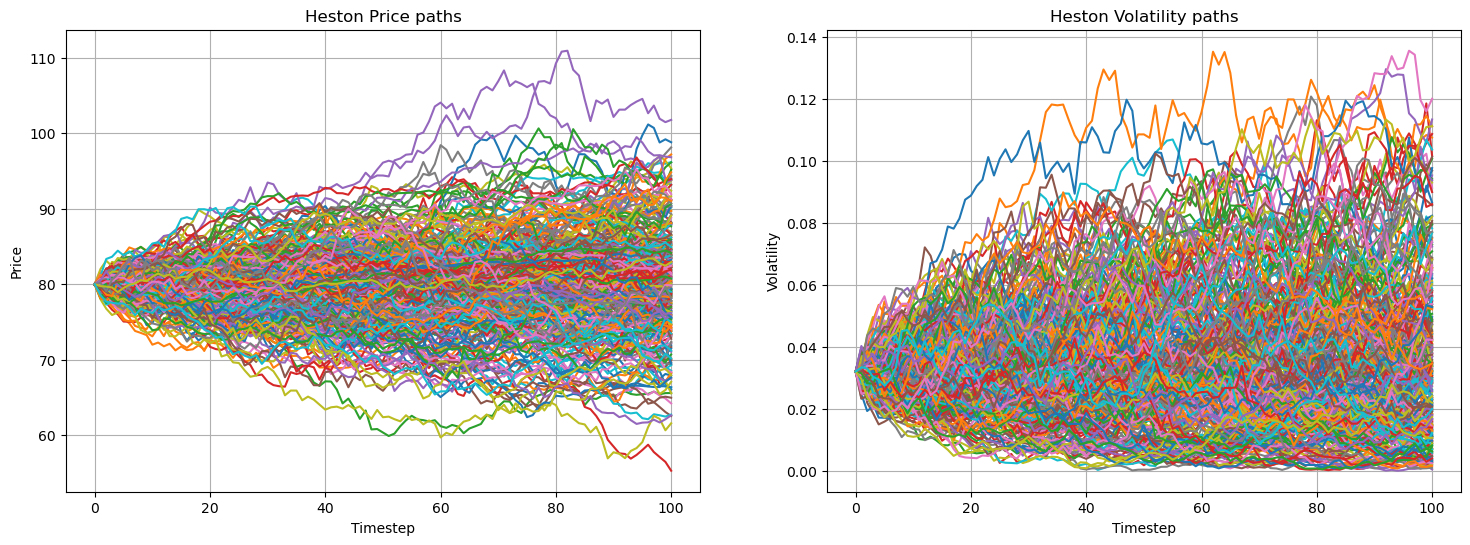

In [94]:
def plot_paths(n):
    fig = plt.figure(figsize=(18, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    ax1.plot(range(len(S)), S[:, :n])
    ax1.grid()
    ax1.set_title("Heston Price paths")
    ax1.set_ylabel("Price")
    ax1.set_xlabel("Timestep")

    ax2.plot(range(len(V)), V[:, :n])
    ax2.grid()
    ax2.set_title("Heston Volatility paths")
    ax2.set_ylabel("Volatility")
    ax2.set_xlabel("Timestep")


plot_paths(300)

In [95]:

def heston_mc(S, K, r, T):

    call_payoff = np.maximum(S - K, 0) * np.exp(-r * T)
    put_payoff = np.maximum(K - S, 0) * np.exp(-r * T)

    call_price = np.mean(call_payoff)
    put_price = np.mean(put_payoff)

    return call_price, put_price

# Price the ATM European call and put options
call_price, put_price = heston_mc(S, K, r, T)

print(f"ATM European Call Price: {call_price:.2f}")
print(f"ATM European Put Price: {put_price:.2f}")

ATM European Call Price: 1.89
ATM European Put Price: 1.87


varying correlation value to -0.70

In [96]:
# Heston model parameters
v0 = 0.032  # Initial variance
kappa_v = 1.85  # Mean reversion speed
theta_v = 0.045  # Long-term variance
xi = 0.35  # Volatility of volatility
rho = -0.70  # Correlation between stock price and volatility (updated to -0.70)
Ite = 1000000  # Number of simulations
M = 100  # Number of time steps

# Other parameters
S0 = 80  # Current stock price
K = S0  # ATM strike price
r = 0.055  # Risk-free rate
T = 3/12  # Time to maturity (3 months)


# Price the ATM European call and put options
# Volatility process paths

cho_matrix = covariance_matrix(rho)

V = SDE_vol(v0, kappa_v, theta_v, sigma_v, T, M, Ite, rand, 1, cho_matrix)

# Underlying price process paths
S = heston_paths(S0, r, V, 0, T, M, cho_matrix)
call_price, put_price = heston_mc(S, K, r, T)

print(f"ATM European Call Price (ρ = -0.70): {call_price:.2f}")
print(f"ATM European Put Price (ρ = -0.70): {put_price:.2f}")

ATM European Call Price (ρ = -0.70): 1.52
ATM European Put Price (ρ = -0.70): 2.19


## Option Greeks

In [97]:
def calculate_greeks(S0, K, r, T):
    # Perturbation amount
    delta_S = S0 * 0.01  # 1% of S0

    # Calculate prices for S0 + delta_S
    call_price_up, put_price_up =  heston_mc(S + delta_S, K, r, T)

    # Calculate prices for S0 - delta_S
    call_price_down, put_price_down = heston_mc(S - delta_S, K, r, T)


    # Calculate prices for S0
    call_price, put_price = heston_mc(S, K, r, T)

    # Delta calculation
    call_delta = (call_price_up - call_price_down) / (2 * np.mean(delta_S))
    put_delta = (put_price_up - put_price_down) / (2 * np.mean(delta_S))

    # Gamma calculation
    call_gamma = (call_price_up - 2 * call_price + call_price_down) / (np.mean(delta_S)**2)
    put_gamma = (put_price_up - 2 * put_price + put_price_down) / (np.mean(delta_S)**2)

    return call_delta, put_delta, call_gamma, put_gamma

# Calculate delta and gamma for rho = -0.30
call_delta_1, put_delta_1, call_gamma_1, put_gamma_1 = calculate_greeks(S, K, r, T)

print(f"ATM European Call Delta (ρ = -0.30): {call_delta_1:.2f}")
print(f"ATM European Put Delta (ρ = -0.30): {put_delta_1:.2f}")

print(f"ATM European Call Gamma (ρ = -0.30): {call_gamma_1:.2f}")
print(f"ATM European Put Gamma (ρ = -0.30): {put_gamma_1:.2f}")

ATM European Call Delta (ρ = -0.30): 0.50
ATM European Put Delta (ρ = -0.30): -0.49
ATM European Call Gamma (ρ = -0.30): 0.12
ATM European Put Gamma (ρ = -0.30): 0.12


In [98]:
# Update rho to -0.70
rho = -0.70

cho_matrix = covariance_matrix(rho)

V = SDE_vol(v0, kappa_v, theta_v, sigma_v, T, M, Ite, rand, 1, cho_matrix)

# Underlying price process paths
S = heston_paths(S0, r, V, 0, T, M, cho_matrix)

# Calculate delta and gamma for rho = -0.70
call_delta_2, put_delta_2, call_gamma_2, put_gamma_2 = calculate_greeks(S, K, r, T)

print(f"ATM European Call Delta (ρ = -0.70): {call_delta_2:.2f}")
print(f"ATM European Put Delta (ρ = -0.70): {put_delta_2:.2f}")

print(f"ATM European Call Gamma (ρ = -0.70): {call_gamma_2:.2f}")
print(f"ATM European Put Gamma (ρ = -0.70): {put_gamma_2:.2f}")

ATM European Call Delta (ρ = -0.70): 0.50
ATM European Put Delta (ρ = -0.70): -0.49
ATM European Call Gamma (ρ = -0.70): 0.12
ATM European Put Gamma (ρ = -0.70): 0.12


## Question 8

Merton Jump Diffusion Model

$$
\begin{equation*}
    dS_t = \left( r - r_j \right) S_t dt + \sigma S_t dZ_t + J_t S_t dN_t
\end{equation*}
$$

Discretized form:

$$
\begin{equation*}
    S_t = S_{t-1} \left( e^{\left(r-r_j-\frac{\sigma^2}{2}\right)dt + \sigma \sqrt{dt} z_t^1}+
    \left(e^{\mu_j+\delta z_t^2}-1 \right) y_t \right)
\end{equation*}
$$

$$
\begin{equation*}
r_j = \lambda \left(e^{\mu_j+\frac{\delta^2}{2}}\right)-1
\end{equation*}
$$

In [99]:
def merton_jump_diffusion(S0,T,r,sigma,mu,delta,lamb):
  Ite = 10000  # Number of simulations (paths)
  M = 100  # Number of steps
  dt = T / M  # Time-step
  SM = np.zeros((M + 1, Ite))
  SM[0] = S0

  # rj
  rj = lamb * (np.exp(mu + 0.5 * delta**2) - 1)
  z1 = rng.normal(0, 1,(M + 1, Ite))
  z2 = rng.normal(0, 1,(M + 1, Ite))
  y = rng.poisson(lamb * dt, (M + 1, Ite))

  for t in range(1, M + 1):
      SM[t] = SM[t - 1] * (
          np.exp((r - rj - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z1[t])
          + (np.exp(mu + delta * z2[t]) - 1) * y[t]
      )
      SM[t] = np.maximum(
          SM[t], 0.00001
      )  # To ensure that the price never goes below zero!

  return SM

In [100]:
def merton_european_option(SM,K,T,r):

  S_T = SM[-1]

  # Compute payoffs
  call_payoffs = np.maximum(S_T - K, 0)
  put_payoffs = np.maximum(K - S_T, 0)

  # Discount and average
  call_price = np.exp(-r * T) * np.mean(call_payoffs)
  put_price = np.exp(-r * T) * np.mean(put_payoffs)

  return call_price,put_price

λ = 0.75

In [101]:
mu = -0.5  # intensity mean
delta = 0.22
r = 0.055  # Risk-free rate
sigma = 0.35  # Volatility
T = 3/12  # Maturity/time
S0 = K = 80

In [102]:
lamb_075 = 0.75  # intensity
SM_lamb_075 = merton_jump_diffusion(S0,T,r,sigma,mu,delta,lamb_075)

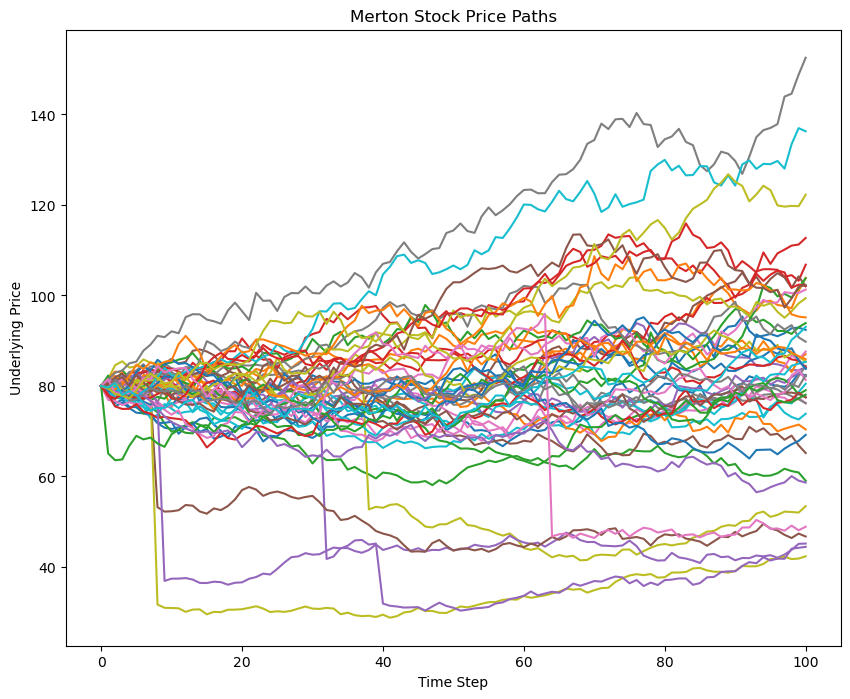

In [130]:
plt.figure(figsize=(10, 8))
plt.plot(SM_lamb_075[:, 100:150])
plt.title("Merton Stock Price Paths")
plt.xlabel("Time Step")
plt.ylabel("Underlying Price")
plt.show()

In [103]:
call_075,put_075 = merton_european_option(SM_lamb_075,K,T,r)
print(f"Call price: {call_075:.2f}")
print(f"Put price: {put_075:.2f}")

Call price: 8.19
Put price: 7.38


In [104]:
assert math.isclose(call_075+K*np.exp(-r*T),S0+put_075,rel_tol=0.5)

## Question 9

λ = 0.25

In [105]:
lamb_025 = 0.25
SM_lamb_025 = merton_jump_diffusion(S0,T,r,sigma,mu,delta,lamb_025)

In [106]:
call_025,put_025 = merton_european_option(SM_lamb_025,K,T,r)
print(f"Call price: {call_025:.2f}")
print(f"Put price: {put_025:.2f}")

Call price: 6.84
Put price: 5.74


In [107]:
assert math.isclose(call_025+K*np.exp(-r*T),S0+put_025,rel_tol=0.5)

## Question 10

https://people.maths.ox.ac.uk/gilesm/mc/mc/lec7.pdf

$delta = \frac{\partial V}{\partial S}$

In [108]:
# use finite difference methods
# Delta = [V(S+h) -  V(S-h)] / 2h
def delta_finite_difference(S0,K,T,r,sigma,mu,delta,lamb,increment=0.01):

  delta_S0_up = S0+increment
  delta_S0_down = S0-increment

  SM_delta_up = merton_jump_diffusion(delta_S0_up,T,r,sigma,mu,delta,lamb)
  delta_call_up, delta_put_up = merton_european_option(SM_delta_up,K,T,r)

  SM_delta_down = merton_jump_diffusion(delta_S0_down,T,r,sigma,mu,delta,lamb)
  delta_call_down, delta_put_down = merton_european_option(SM_delta_down,K,T,r)

  call_delta = (delta_call_up - delta_call_down) / 2*S0*increment
  put_delta = (delta_put_up - delta_put_down) / 2*S0*increment

  return call_delta, put_delta


$gamma = \frac{\partial ^2 V}{\partial S^2}$

In [109]:
# use finite difference methods
# Gamma = [V(S+h) - 2V(S) + V(S-h)] / h^2
def gamma_finite_difference(S0,K,T,r,sigma,mu,gamma,lamb,increment=0.01):
  delta_S0_up = S0+increment
  delta_S0_down = S0-increment

  # V(S + increment)
  SM_gamma_up = merton_jump_diffusion(delta_S0_up,T,r,sigma,mu,delta,lamb)
  gamma_call_up, gamma_put_up = merton_european_option(SM_gamma_up,K,T,r)
  # V(S - increment)
  SM_gamma_down = merton_jump_diffusion(delta_S0_down,T,r,sigma,mu,delta,lamb)
  gamma_call_down, gamma_put_down = merton_european_option(SM_gamma_down,K,T,r)

  # V(S)
  SM_gamma_mid = merton_jump_diffusion(S0,T,r,sigma,mu,delta,lamb)
  gamma_call_mid, gamma_put_mid = merton_european_option(SM_gamma_mid,K,T,r)

  call_gamma = (gamma_call_up - 2*gamma_call_mid + gamma_call_down) / (S0*increment)**2
  put_gamma = (gamma_put_up - 2*gamma_put_mid + gamma_put_down) / (S0*increment)**2

  return call_gamma, put_gamma


λ = 0.75

In [110]:
call_delta_075, put_delta_075 = delta_finite_difference(S0,K,T,r,sigma,mu,delta,lamb_075)
print(f"Call delta (λ = 0.75): {call_delta_075:.4f}")
print(f"Put delta (λ = 0.75): {put_delta_075:.4f}")

Call delta (λ = 0.75): 0.0232
Put delta (λ = 0.75): 0.0041


In [111]:
call_gamma_075, put_gamma_075 = gamma_finite_difference(S0,K,T,r,sigma,mu,delta,lamb_075)
print(f"Call gamma (λ = 0.75): {call_gamma_075:.4f}")
print(f"Put gamma (λ = 0.75): {put_gamma_075:.4f}")

Call gamma (λ = 0.75): 0.3456
Put gamma (λ = 0.75): 0.3420


λ = 0.25

In [112]:
lamb_025 = 0.25
call_delta_025, put_delta_025 = delta_finite_difference(S0,K,T,r,sigma,mu,delta,lamb_025)
print(f"Call delta (λ = 0.25): {call_delta_025:.4f}")
print(f"Put delta (λ = 0.25): {put_delta_025:.4f}")

Call delta (λ = 0.25): 0.0742
Put delta (λ = 0.25): 0.0679


In [113]:
call_gamma_025, put_gamma_025 = gamma_finite_difference(S0,K,T,r,sigma,mu,delta,lamb_025)
print(f"Call gamma (λ = 0.25): {call_gamma_025:.4f}")
print(f"Put gamma (λ = 0.25): {put_gamma_025:.4f}")

Call gamma (λ = 0.25): -0.1465
Put gamma (λ = 0.25): 0.0240


#Step 2

## Question 13

American options use LSMC because of early exercise option

https://berthine.github.io/doc/berthine_master-document.pdf , Page 18-21

https://people.math.ethz.ch/~hjfurrer/teaching/LongstaffSchwartzAmericanOptionsLeastSquareMonteCarlo.pdf , Page 120-124

In [114]:
def lsmc_payoff(S_T, K, T, r , n_steps, option_type):

    n_paths = S_T.shape[1]
    dt = T / n_steps
    cash_flows = np.zeros((n_steps + 1, n_paths))

    # Set terminal payoffs at maturity
    if option_type == 'call':
        cash_flows[n_steps] = np.maximum(S_T[n_steps] - K, 0)
    else:
        cash_flows[n_steps] = np.maximum(K - S_T[n_steps], 0)

    exercised = np.zeros(n_paths, dtype=bool)

    for t in range(n_steps - 1, 0, -1):

        immediate_exercise = np.maximum(S_T[t] - K, 0) if option_type == 'call' else np.maximum(K - S_T[t], 0)

        if option_type == 'call':
            itm = (S_T[t] > K) & ~exercised
        else:
            itm = (S_T[t] < K) & ~exercised

        if np.sum(itm) > 0:

            X_itm = S_T[t, itm]

            # Calculate discounted future cash flows
            future_cf = np.zeros(n_paths)
            for i in range(t + 1, n_steps + 1):
                future_cf += cash_flows[i] * np.exp(-r * (i - t) * dt)

            Y_itm = future_cf[itm]
            X_design = np.column_stack([
                np.ones(len(X_itm)),
                X_itm,
                X_itm**2,
                X_itm**3
            ])


            beta = np.linalg.lstsq(X_design, Y_itm, rcond=None)[0]
            continuation_values = X_design @ beta


            #  early exercise vs holding
            exercise_decision = immediate_exercise[itm] > continuation_values

            # Get indices of paths to exercise at time t
            exercise_idx = np.where(itm)[0][exercise_decision]

            if len(exercise_idx) > 0:
                # Record cash flow at time t for exercised paths
                cash_flows[t, exercise_idx] = immediate_exercise[exercise_idx]

                # Mark these paths as exercised
                exercised[exercise_idx] = True
                cash_flows[t + 1: n_steps + 1, exercise_idx] = 0

    # Discount to time 0
    discounted_payoffs = np.zeros(n_paths)
    for t in range(1, n_steps + 1):
        discounted_payoffs += cash_flows[t] * np.exp(-r * t * dt)

    return discounted_payoffs

In [115]:
def heston_price_paths(S0, K, r, T, Ite, M):
    dt = T / M
    # Initialize a 2D array to store all paths at all time steps
    paths = np.zeros((M + 1, Ite))
    paths[0] = np.full(Ite, S0)  # Initial stock price

    # Initialize variance
    v = np.full(Ite, v0)

    # Generate paths
    for t in range(1, M + 1):
        Z1 = rng.normal(0, 1, Ite)
        Z2 = rho * Z1 + np.sqrt(1 - rho**2) * rng.normal(0, 1, Ite)

        v = np.maximum(v + kappa_v * (theta_v - v) * dt + xi * np.sqrt(v * dt) * Z2, 0)
        paths[t] = paths[t-1] * np.exp((r - 0.5 * v) * dt + np.sqrt(v * dt) * Z1)

    return paths

In [116]:
def heston_american_option(S0, K, T, r, rho, option_type):
    Ite = 1000000  # Number of simulations (paths)
    M = 100  # Number of steps

    # Generate random numbers and Cholesky matrix locally
    rand = random_number_gen(M, Ite)
    cho_matrix = covariance_matrix(rho)

    # Simulate variance paths
    V = SDE_vol(v0, kappa_v, theta_v, sigma_v, T, M, Ite, rand, 1, cho_matrix)


    # Simulate price paths
    S = heston_paths(S0, r, V, 0, T, M, cho_matrix)


    # # Use S for LSMC
    fitted_payoffs = lsmc_payoff(S, K, T, r, M, option_type)
    price = np.mean(fitted_payoffs)

    return price

rho = -0.30

In [117]:
# Heston model parameters
rho = -0.30  # Correlation between stock price and volatility

# Other parameters
S0 = 80  # Current stock price
K = S0  # ATM strike price
r = 0.055  # Risk-free rate
T = 3/12  # Time to maturity (3 months)

In [118]:
america_call_heston_030 = heston_american_option(S0,K,T,r,rho,'call')
america_put_heston_030 = heston_american_option(S0,K,T,r,rho,'put')
print(f"American call price: {america_call_heston_030:.2f}")
print(f"American put price: {america_put_heston_030:.2f}")

American call price: 3.54
American put price: 2.53


rho = -0.70

### Merton model

In [119]:
def merton_american_option(SM,K,T,r,option_type):
  Ite = 10000  # Number of simulations (paths)
  M = 100  # Number of steps
  fitted_payoffs= lsmc_payoff(SM,K,T,r,M,option_type)
  price = np.mean(fitted_payoffs)

  return price

λ = 0.75

In [120]:
america_call_merton_075 = merton_american_option(SM_lamb_075,K,T,r,'call')
america_put_merton_075 = merton_american_option(SM_lamb_075,K,T,r,'put')
print(f"American call price: {america_call_merton_075:.2f}")
print(f"American put price: {america_put_merton_075:.2f}")

American call price: 9.45
American put price: 7.78


In [121]:
assert math.isclose(america_call_merton_075+K*np.exp(-r*T),S0+america_put_merton_075,rel_tol=0.5)

## Question 14

(UAI)up-and-in call

In [122]:
def up_and_in_barrier_option(price_paths, K, B, r, T):
  # Check if the barrier is breached for each path
    barrier_breached = np.max(price_paths, axis=0) >= B

    # Calculate terminal payoffs for both call and put
    call_payoffs = np.maximum(price_paths[-1] - K, 0)
    put_payoffs = np.maximum(K - price_paths[-1], 0)

    # Apply barrier condition: payoff is zero if barrier is not breached
    call_payoffs = call_payoffs * barrier_breached
    put_payoffs = put_payoffs * barrier_breached

    # Discount payoffs to present value
    discount_factor = np.exp(-r * T)
    call_price = np.mean(call_payoffs) * discount_factor
    put_price = np.mean(put_payoffs) * discount_factor

    return call_price, put_price

In [123]:
def heston_up_and_in_option(S0, K, B, T, r):

    Ite = 10000
    M = 100
    price_paths = heston_price_paths(S0, K, r, T, Ite, M)

    return up_and_in_barrier_option(price_paths, K, B, r, T)

In [124]:
B = K = 95
uai_heston_call, uai_heston_put = heston_up_and_in_option(S0,K,B,T,r)
print(f"European UAI call price: {uai_heston_call:.2f}")
print(f"European UAI put price: {uai_heston_put:.2f}")

European UAI call price: 0.08
European UAI put price: 0.06


In [125]:
assert math.isclose(uai_heston_call+K*np.exp(-r*T),S0+uai_heston_put,rel_tol=0.5)

## Question 15

European Down-and-In (Knock In Barrier) Option

In [126]:
def down_in_barrier(SM,K,T,r,sigma,mu,delta,lamb, barrier):
    S_T = SM[-1]

    barrier_hit = np.any(S_T <= barrier, axis=0)

    # Calculate payoff (only valid if barrier is hit)
    call_payoff = np.where(barrier_hit, np.maximum(S_T - K, 0), 0)
    put_payoff =  np.where(barrier_hit, np.maximum(K - S_T, 0), 0)

    # Calculate option price
    call_price = np.exp(-r * T) * np.mean(call_payoff)
    put_price = np.exp(-r * T) * np.mean(put_payoff)

    return call_price, put_price

In [127]:
mu = -0.5  # intensity mean
delta = 0.22
r = 0.055  # Risk-free rate
sigma = 0.35  # Volatility
T = 3/12  # Maturity/time
S0 = 80
lamb = 0.75

In [128]:
K = barrier = 65
dai_call, dai_put = down_in_barrier(SM_lamb_075,K,T,r,sigma,mu,delta,lamb,barrier)
print(f"European DAI Barrier call price: {dai_call:.2f}")
print(f"European DAI Barrier put price: {dai_put:.2f}")

European DAI Barrier call price: 18.46
European DAI Barrier put price: 2.86


In [129]:
assert math.isclose(dai_call+K*np.exp(-r*T),S0+dai_put,rel_tol=0.5)